In [22]:
# Import the necessary modules
#For Deep Learning
from tensorflow import keras as keras
from tensorflow.keras import datasets
from tensorflow.keras.layers import Dense, Flatten, Dropout, Activation, BatchNormalization, Convolution2D, Normalization, Input, GRU, LSTM, Bidirectional
from tensorflow.keras.regularizers import l2
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from keras import callbacks
from keras.callbacks import EarlyStopping
#For graph display
from IPython.display import clear_output
#For data visualisation and manipulation
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#For splitting datasets and 
import sklearn 
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error,mean_absolute_error, r2_score
import matplotlib.pyplot as plt

In [23]:
#Read in the data frame
df = pd.read_csv('all_data_organised.csv', parse_dates = ['date'], index_col = 'date',dayfirst=True)

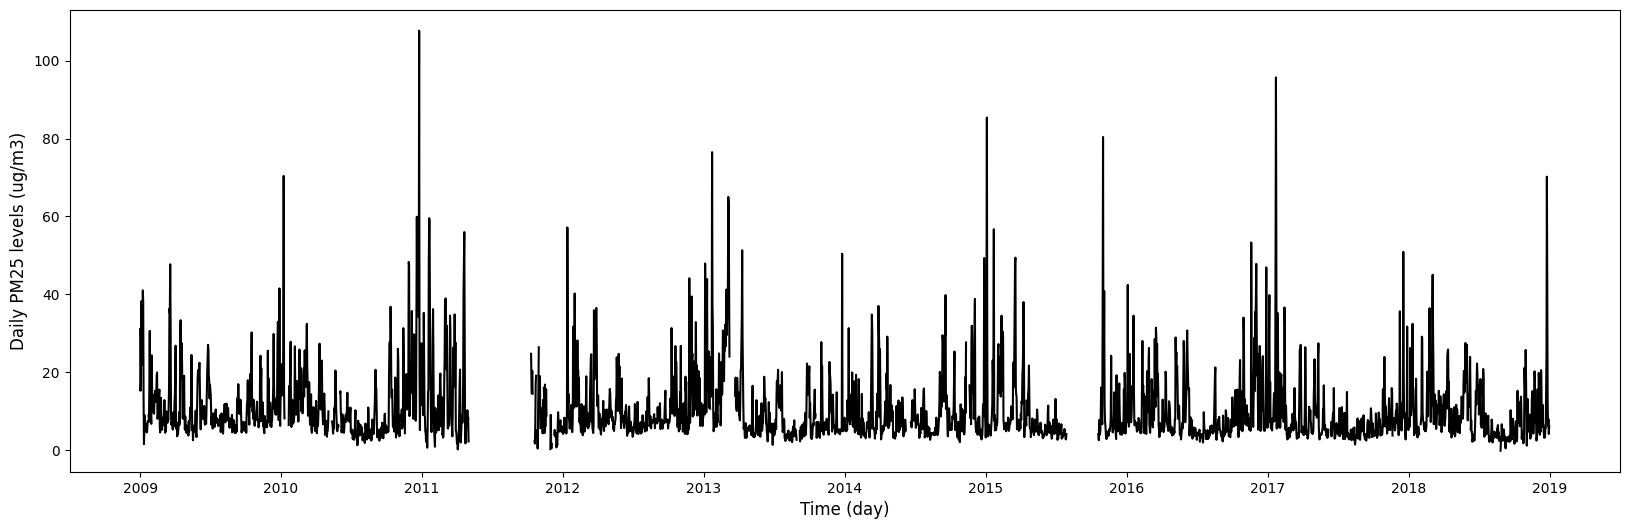

In [24]:
#Create a function to map PM2.5 as a time series
def timeseries (x_axis, y_axis, x_label, y_label):
    plt.figure(figsize = (20, 6))
    plt.plot(x_axis, y_axis, color ='black')
    plt.xlabel(x_label, {'fontsize': 12}) 
    plt.ylabel(y_label, {'fontsize': 12})


timeseries(df.index, df['PM25'], 'Time (day)','Daily PM25 levels (ug/m3)')

In [25]:
df['PM25'].interpolate(inplace=True)
df['temp'].interpolate(inplace=True)
df['r_hum'].interpolate(inplace=True)
df['wdsp'].interpolate(inplace=True)

In [26]:
# Outlier detection
up_p = df['PM25'].mean() + 2*df['PM25'].std()
low_p = df['PM25'].mean() - 2*df['PM25'].std()
# Replace outlier by interpolation for base consumption
df.loc[df['PM25'] > up_p, 'PM25'] = np.nan
df.loc[df['PM25'] < low_p, 'PM25'] = np.nan
df['PM25'].interpolate(inplace=True)

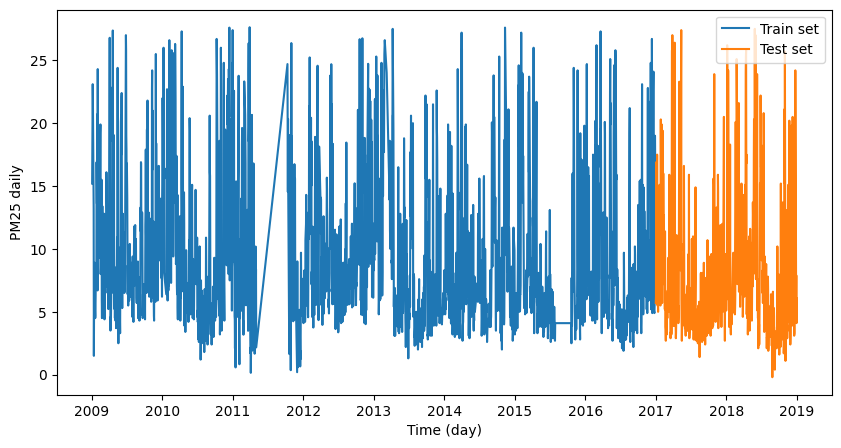

In [27]:
# Split into test and train
train_size = int(len(df)*0.8)
train_dataset, test_dataset = df.iloc[:train_size], df.iloc[train_size:]
# Plot train and test data
plt.figure(figsize = (10, 5))
plt.plot(train_dataset.PM25)
plt.plot(test_dataset.PM25)
plt.xlabel('Time (day)')
plt.ylabel('PM25 daily')
plt.legend(['Train set', 'Test set'], loc='upper right')

In [28]:
# Split train data to X and y
X_train = train_dataset.drop('PM25', axis = 1)
y_train = train_dataset.loc[:,['PM25']]
# Split test data to X and y
X_test = test_dataset.drop('PM25', axis = 1)
y_test = test_dataset.loc[:,['PM25']]

In [29]:
# Different scaler for input and output
scaler_x = MinMaxScaler(feature_range = (0,1))
scaler_y = MinMaxScaler(feature_range = (0,1))
# Fit the scaler using available training data
input_scaler = scaler_x.fit(X_train)
output_scaler = scaler_y.fit(y_train)
# Apply the scaler to training data
train_y_norm = output_scaler.transform(y_train)
train_x_norm = input_scaler.transform(X_train)
# Apply the scaler to test data
test_y_norm = output_scaler.transform(y_test)
test_x_norm = input_scaler.transform(X_test)

In [30]:
# Create a 3D input
def create_dataset (X, y, time_steps = 1):
    Xs, ys = [], []
    for i in range(len(X)-time_steps):
        v = X[i:i+time_steps, :]
        Xs.append(v)
        ys.append(y[i+time_steps])
    return np.array(Xs), np.array(ys)
TIME_STEPS = 30
#Create the test dataset
X_test, y_test = create_dataset(test_x_norm, test_y_norm, TIME_STEPS)
#Create the train dataset
X_train, y_train = create_dataset(train_x_norm, train_y_norm, TIME_STEPS)


In [31]:
def create_model(units, m):
    model = Sequential()
    model.add(m (units = 128, return_sequences = True,
                input_shape = [X_train.shape[1], X_train.shape[2]]))
    model.add(Dropout(0.2))
    model.add(m (units = 64))
    model.add(Dropout(0.2))
    model.add(Dense(units = 1))
    #Compile model
    model.compile(loss='mse', optimizer='adam')
    return model

# GRU and LSTM
model_gru = create_model(64, GRU)

In [32]:
# Fit  GRU
def fit_model(model):
    early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 10)
    history = model.fit(X_train, y_train, epochs = 100, validation_split = 0.2, batch_size = 32, shuffle = False, callbacks = [early_stop])
    return history


history_gru = fit_model(model_gru)

Epoch 1/100
73/73 [==============================] - 9s 55ms/step - loss: 0.0655 - val_loss: 0.0336
Epoch 2/100
73/73 [==============================] - 3s 40ms/step - loss: 0.0497 - val_loss: 0.0328
Epoch 3/100
73/73 [==============================] - 4s 56ms/step - loss: 0.0477 - val_loss: 0.0322
Epoch 4/100
73/73 [==============================] - 5s 71ms/step - loss: 0.0462 - val_loss: 0.0321
Epoch 5/100
73/73 [==============================] - 5s 62ms/step - loss: 0.0448 - val_loss: 0.0319
Epoch 6/100
73/73 [==============================] - 4s 49ms/step - loss: 0.0445 - val_loss: 0.0320
Epoch 7/100
73/73 [==============================] - 4s 50ms/step - loss: 0.0442 - val_loss: 0.0317
Epoch 8/100
73/73 [==============================] - 3s 47ms/step - loss: 0.0433 - val_loss: 0.0317
Epoch 9/100
73/73 [==============================] - 3s 40ms/step - loss: 0.0435 - val_loss: 0.0319
Epoch 10/100
73/73 [==============================] - 3s 42ms/step - loss: 0.0436 - val_loss: 0.0316

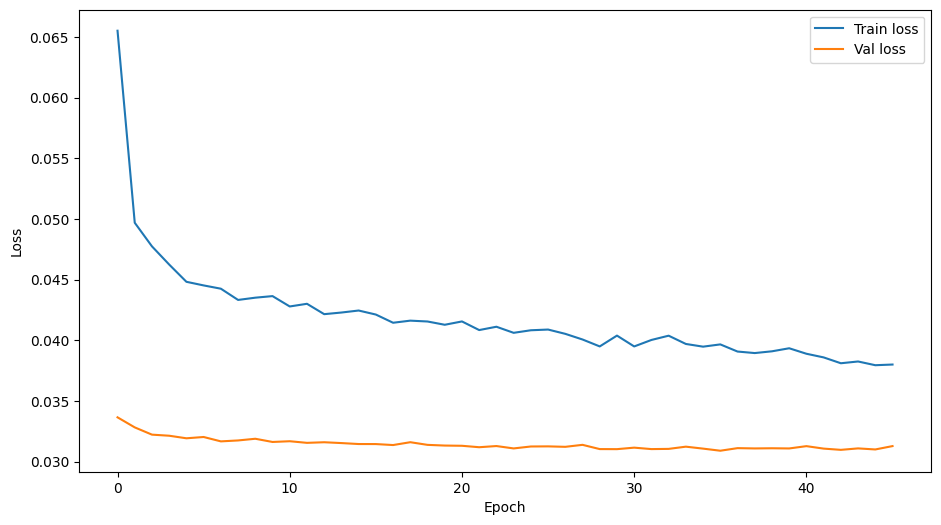

In [33]:
# Plot train loss and validation loss
def plot_loss (history):
    plt.figure(figsize = (11, 6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train loss', 'Val loss'], loc='upper right')

plot_loss (history_gru)

In [34]:
y_test = scaler_y.inverse_transform(y_test)
y_train = scaler_y.inverse_transform(y_train)

22/22 [==============================] - 1s 9ms/step


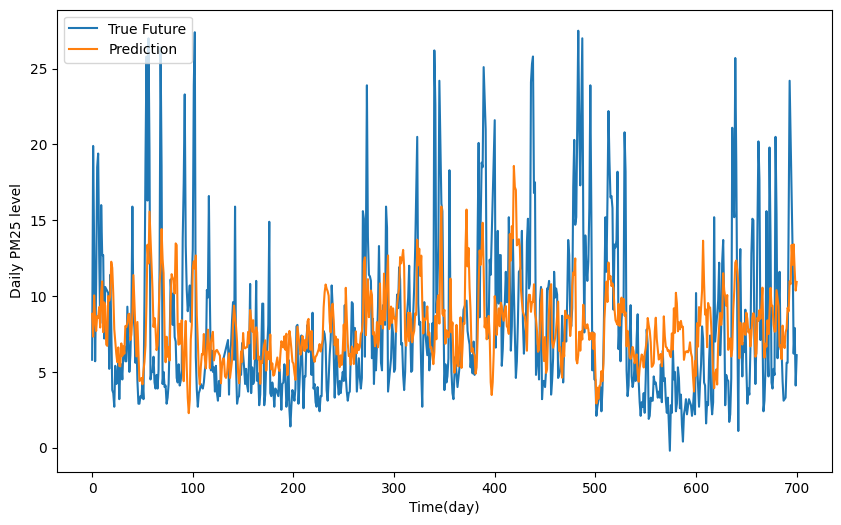

In [35]:
# Make prediction
def prediction(model):
    prediction = model.predict(X_test)
    prediction = scaler_y.inverse_transform(prediction)
    return prediction


prediction_gru = prediction(model_gru)
# Plot true future vs prediction
def plot_future(prediction, y_test):
    plt.figure(figsize=(10, 6))
    range_future = len(prediction)
    plt.plot(np.arange(range_future), np.array(y_test),label='True Future')     
    plt.plot(np.arange(range_future),np.array(prediction),label='Prediction')
    plt.legend(loc='upper left')
    plt.xlabel('Time(day)')
    plt.ylabel('Daily PM25 level')



plot_future(prediction_gru, y_test)

In [36]:
# Define a function to calculate MAE and RMSE
def evaluate_prediction(predictions, actual, model_name):
    errors = predictions - actual
    mse = np.square(errors).mean()
    rmse = np.sqrt(mse)
    mae = np.abs(errors).mean()
    print(model_name + ':')
    print('Mean Absolute Error: {:.4f}'.format(mae))
    print('Root Mean Square Error: {:.4f}'.format(rmse))
    print('Mean Squared Error: {:.4f}'.format(mse))



evaluate_prediction(prediction_gru, y_test, 'GRU')

GRU:
Mean Absolute Error: 3.7141
Root Mean Square Error: 5.0384
Mean Squared Error: 25.3857


In [37]:
# Plot histoy and future data
def plot_history_future(y_train, prediction, model_name):
    
    plt.figure(figsize=(10, 6))
    
    range_history = len(y_train)
    range_future = list(range(range_history, range_history + len(prediction)))

    plt.plot(np.arange(range_history), np.array(y_train), label='History')
    plt.plot(range_future, np.array(prediction),label='Prediction')

    plt.title('History and prediction for ' + model_name)
    plt.legend(loc='upper right')
    plt.xlabel('Time (day)')
    plt.ylabel('Daily water consumption ($m^3$/capita.day)')


In [38]:
def forecast(X_input, time_steps):
    X = input_scaler.transform(X_input)
    Xs = []
    for i in range(len(X) - time_steps):
        v = X[i:i+time_steps, :]
        Xs.append(v)
        
    X_transformed = np.array(Xs)

    prediction = model_gru.predict(X_transformed)
    prediction_actual = scaler_y.inverse_transform(prediction)
    return prediction_actual

In [39]:
#Testing for Cork
new_df = pd.read_csv('All_Cork_Data.csv', parse_dates = ['date'], index_col = 'date',dayfirst=True)
print(df)
print(new_df)

features = ['temp', 'r_hum','wdsp', 'msl']

x_new = new_df[features]

#Testing for Dublin
# new_df = pd.read_csv(r'C:\Users\paraicoreilly\Desktop\project_code\PM\PM25_test.csv')

# features = ['temp', 'r_hum','wdsp', 'msl']

# x_new = new_df[features]

             PM25  temp  r_hum  wdsp   msl
date                                      
2009-01-01    NaN   3.4   90.4   7.8  1029
2009-01-02  15.20   3.7   77.4   8.5  1031
2009-01-03  17.40   2.8   67.0   6.1  1030
2009-01-04  20.25   0.9   89.7   7.4  1024
2009-01-05  23.10   0.8   87.8   7.4  1026
...           ...   ...    ...   ...   ...
2018-12-27  12.80   9.0   87.8   3.5  1026
2018-12-28   6.20  10.3   88.4   6.5  1028
2018-12-29   7.90  11.0   90.0   9.9  1030
2018-12-30   4.10  10.5   85.6   7.6  1034
2018-12-31   6.10   9.5   78.1   7.5  1035

[3652 rows x 5 columns]
            PM25  temp  r_hum   msl  wdsp
date                                     
2009-01-01  25.0   5.0     89  1026     9
2009-01-02  19.0   4.3     81  1028     8
2009-01-03  14.0   3.4     80  1029     4
2009-01-04  50.0   3.0     89  1024     2
2009-01-05  26.0   2.1     90  1024     3
...          ...   ...    ...   ...   ...
2019-12-27  10.4  11.4     93  1024     6
2019-12-28  10.6  10.5     86  1028   

125/125 [==============================] - 1s 10ms/step


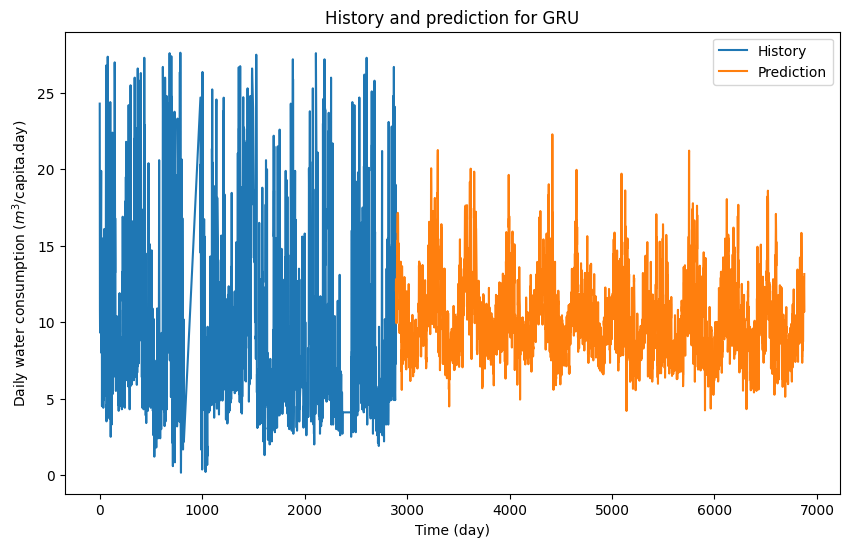

In [40]:
prediction = forecast(x_new, TIME_STEPS)
plot_history_future(y_train, prediction,'GRU')